In [43]:
import os
from sklearn.tree import DecisionTreeClassifier

import pandas as pd

from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate


from pathlib import Path
import sys
sys.path.append(os.path.abspath('..'))

In [44]:
# load datasets
data_path = Path(os.getcwd()).parent.parent / "data" / "dataset_diabetes" / "clsf_data"

target_variable = "readmit_30_days"
sensitive_attribute = "race"

X_train_res_target_wos = pd.read_csv(data_path / "X_train_res_target_wos.csv")
Y_train_res_target_wos = pd.read_csv(data_path / "Y_train_res_target_wos.csv")[target_variable]
A_train_res_target_wos = pd.read_csv(data_path / "A_train_res_target_wos.csv").iloc[:, 0]

X_test = pd.read_csv(data_path / "X_test_split.csv")
X_A_test = pd.read_csv(data_path / "X_A_test_split.csv")
Y_test = pd.read_csv(data_path / "Y_test_split.csv")[target_variable]
A_test = pd.read_csv(data_path / "A_test_split.csv")[sensitive_attribute]

In [45]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [46]:
threshold_opt = ThresholdOptimizer(
    estimator=decision_tree,
    constraints="demographic_parity",
    # constraints="false_negative_rate_parity",
    # constraints="true_positive_rate_parity",
    # constraints="equalized_odds",
    # objective="true_positive_rate",
    objective="balanced_accuracy_score",
    predict_method='predict_proba'
)

In [47]:
threshold_opt.fit(X_train_res_target_wos, Y_train_res_target_wos, sensitive_features=A_train_res_target_wos)
model_pred = threshold_opt.predict(X_test, sensitive_features=A_test)

                 true_positive_rate  balanced_accuracy  selection_rate
race                                                                  
AfricanAmerican            0.589800           0.592952        0.425450
Caucasian                  0.569087           0.586743        0.415083
Other                      0.589744           0.619106        0.373945
Unknown                    0.558824           0.560742        0.447059


array([[<Axes: title={'center': 'true_positive_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

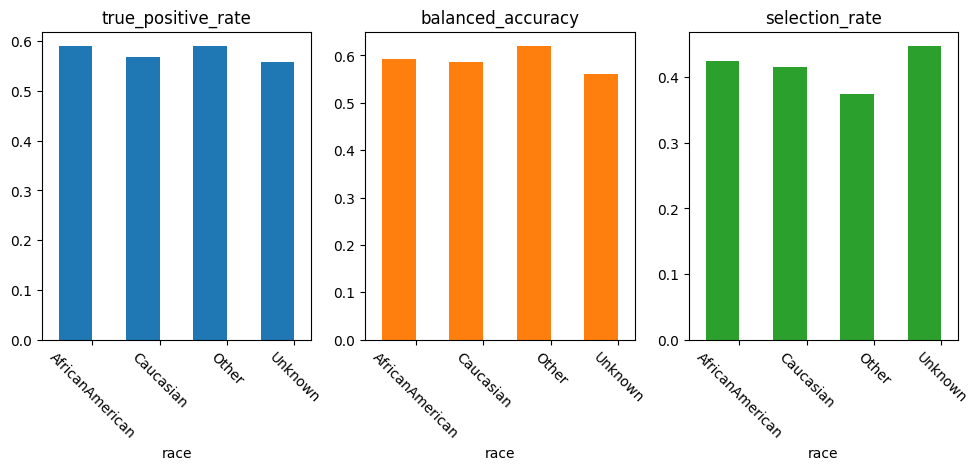

In [48]:
metrics_dict = {
    "true_positive_rate" : true_positive_rate,
    "balanced_accuracy" : balanced_accuracy_score,
    "selection_rate" : selection_rate,
}

metric_frame = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=model_pred,
    sensitive_features=A_test
)

# The disaggregated metrics
print(metric_frame.by_group)

metric_frame.by_group.plot.bar(
    subplots=True, layout=[1, 4], figsize=[16, 4], legend=None, rot=-45, position=1
)

In [49]:
confusion_matrix(Y_test, model_pred)

array([[10917,  7165],
       [  968,  1303]], dtype=int64)